In [1]:
# import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from scipy import misc
import glob
import cv2

from numpy.random import seed
seed(1)
import matplotlib
matplotlib.use('Agg')
import os
import h5py
import scipy.io as sio
import gc

from keras.models import load_model, Model, Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
		 	  Activation, Dense, Dropout, ZeroPadding2D)
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from keras.layers.advanced_activations import ELU
import openvino

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#import os 
#os.chdir("/content/drive") 
#path = "/content/drive/My Drive/fall_detection"
#os.chdir(path)
#os.listdir(path)


In [4]:
## fun
def rgb2grey(pic):
    size = np.shape(pic)
    pic = np.array(pic)
    W = size[0]
    H = size[1]
    rim = pic[:,:,0]
    gim = pic[:,:,1]
    bim = pic[:,:,2]
    return  0.299 * rim + 0.587 * gim + 0.114 * bim


**Test whether the image is correctly loaded.**

c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


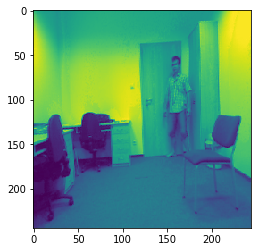

In [5]:
# test
%matplotlib inline 
image_size=244
frame = 10
strid = 3
I = misc.imread("data/UR/fall-01-cam0-rgb/fall-01-cam0-rgb-001.png")
I = rgb2grey(I)
I = cv2.resize(I, (image_size,image_size))
# I.resize((image_size,image_size))
plt.imshow(I)

In [6]:
file_path = 'data/UR'
fall_period = np.array([[93,135],[55,85],[161,200],[27,71],[92,140],[31,70],[96,127],[40,82],[134,175],[58,85],[61,105],[36,85],[54,78],[28,51],[36,71]])

#floders 
im_folders1 = glob.glob('data/UR//fall*')
im_folders2 = glob.glob('data/UR//adl*')
im_folders3 = glob.glob('data/UR//*')
im_folders1.sort()
np.random.shuffle(im_folders3)

print(im_folders1)
print(im_folders2)
print(im_folders3)
final_data = []
final_label=[]
period_idx =0

['data/UR\\fall-01-cam0-rgb', 'data/UR\\fall-02-cam0-rgb', 'data/UR\\fall-03-cam0-rgb', 'data/UR\\fall-04-cam0-rgb', 'data/UR\\fall-05-cam0-rgb', 'data/UR\\fall-06-cam0-rgb', 'data/UR\\fall-07-cam0-rgb', 'data/UR\\fall-08-cam0-rgb', 'data/UR\\fall-09-cam0-rgb', 'data/UR\\fall-10-cam0-rgb', 'data/UR\\fall-11-cam0-rgb', 'data/UR\\fall-12-cam0-rgb', 'data/UR\\fall-13-cam0-rgb', 'data/UR\\fall-14-cam0-rgb', 'data/UR\\fall-15-cam0-rgb']
[]
['data/UR\\fall-04-cam0-rgb', 'data/UR\\fall-08-cam0-rgb', 'data/UR\\fall-07-cam0-rgb', 'data/UR\\fall-03-cam0-rgb', 'data/UR\\fall-11-cam0-rgb', 'data/UR\\fall-05-cam0-rgb', 'data/UR\\fall-02-cam0-rgb', 'data/UR\\fall-14-cam0-rgb', 'data/UR\\fall-01-cam0-rgb', 'data/UR\\fall-15-cam0-rgb', 'data/UR\\fall-10-cam0-rgb', 'data/UR\\fall-09-cam0-rgb', 'data/UR\\fall-13-cam0-rgb', 'data/UR\\fall-12-cam0-rgb', 'data/UR\\fall-06-cam0-rgb']


**Now, we start to upload the images from each file, and transfer them into optical flow.**


In [7]:
# loop all the files
for i,folder in enumerate(im_folders1):
    print (i,folder)
    pics = glob.glob(folder+'//*')
    image_set = []
    for pic in pics:
        I = misc.imread(pic)
        I = rgb2grey(I)
        I = cv2.resize(I, (image_size,image_size))
        image_set.append(I)
    image_set = np.array(image_set)
    print("imgs size:",np.shape(image_set))

    ## cal the optical flow:
    opflowx = []
    opflowy = []
    for k in range(len(image_set)-1):
        flow = cv2.calcOpticalFlowFarneback(image_set[k] ,image_set[k+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        opflowx.append(flow[:,:,0])
        opflowy.append(flow[:,:,1])
    del image_set
    
    opflow_set = []
    for j in range(0,len(opflowx)-frame,strid):
        xy = opflowx[j:j+frame]+opflowy[j:j+frame]
        opflow_set.append(xy)
    del opflowx,opflowy
    
    final_data += opflow_set  
    opflow_set = np.array(opflow_set)
    print("stacked size:",np.shape(opflow_set))
    #opflow_set = [xxxxxxx(frame),yyyyyyy(frame),xxxxxxx,yyyyyyy...]

    temp_label =[]

    for patch_idx in range(0,len(opflow_set)):
        #print("patch size:",np.shape(datax[patch_idx]))
        patch =[]        
        patch = opflow_set[patch_idx]
        if (folder in im_folders1 and patch_idx >= (fall_period[period_idx][0]-5) and 
          patch_idx <= (fall_period[period_idx][1]-5)):  #label fall
            temp_label.append(1)
        else:
            temp_label.append(0)
    del opflow_set
    
    final_label.append(temp_label)
    print("label size:",np.shape(temp_label))
    if folder in im_folders1:
        period_idx +=1

0 data/UR\fall-01-cam0-rgb


c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


imgs size: (160, 244, 244)
stacked size: (50, 20, 244, 244)
label size: (50,)
1 data/UR\fall-02-cam0-rgb
imgs size: (110, 244, 244)
stacked size: (33, 20, 244, 244)
label size: (33,)
2 data/UR\fall-03-cam0-rgb
imgs size: (215, 244, 244)
stacked size: (68, 20, 244, 244)
label size: (68,)
3 data/UR\fall-04-cam0-rgb
imgs size: (96, 244, 244)
stacked size: (29, 20, 244, 244)
label size: (29,)
4 data/UR\fall-05-cam0-rgb
imgs size: (151, 244, 244)
stacked size: (47, 20, 244, 244)
label size: (47,)
5 data/UR\fall-06-cam0-rgb
imgs size: (100, 244, 244)
stacked size: (30, 20, 244, 244)
label size: (30,)
6 data/UR\fall-07-cam0-rgb
imgs size: (156, 244, 244)
stacked size: (49, 20, 244, 244)
label size: (49,)
7 data/UR\fall-08-cam0-rgb
imgs size: (91, 244, 244)
stacked size: (27, 20, 244, 244)
label size: (27,)
8 data/UR\fall-09-cam0-rgb
imgs size: (185, 244, 244)
stacked size: (58, 20, 244, 244)
label size: (58,)
9 data/UR\fall-10-cam0-rgb
imgs size: (130, 244, 244)
stacked size: (40, 20, 244, 24

In [11]:
# above is label porcess    
final_data = np.array(final_data)

#final_label = sum(final_label, []) ## flatten
print("finallebel",np.shape(final_label))
print("finaldata",np.shape(final_data))

finallebel (566,)
finaldata (566, 20, 244, 244)


**divide the data set into training set and test set**

In [19]:
final_data_size = np.shape(final_label)
final_data_size = final_data_size[0]

trainx = final_data[:int(final_data_size*0.7)]
trainy = final_label[:int(final_data_size*0.7)]
testx = final_data[int(final_data_size*0.7):]
testy = final_label[int(final_data_size*0.7):]
trainx = trainx.transpose(0,3,2,1)   #
testx = testx.transpose(0,3,2,1)   #

print('trainx shape:',np.shape(trainx))
print('trainy shape:',np.shape(trainy))
print('testx shape:',np.shape(testx))
print('testny shape:',np.shape(testy))

trainx shape: (396, 244, 244, 20)
trainy shape: (396,)
testx shape: (170, 244, 244, 20)
testny shape: (170,)


**Build the vgg model**

In [13]:
# hyper parameters
learning_rate = 0.0001

In [14]:
num_features = num_features = 4096

model = Sequential()

model.add(ZeroPadding2D((1, 1), input_shape=(image_size, image_size, frame*2)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(num_features, name='fc6', kernel_initializer='glorot_uniform'))

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.9))
model.add(Dense(4096, name='fc2', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add( Dense(1, name='predictions',kernel_initializer='glorot_uniform'))
model.add(Activation('sigmoid',name = 'Sigmoid'))

adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
    epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy',
      metrics=['accuracy'])

W0412 21:16:02.649930  1724 deprecation.py:506] From c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0412 21:16:02.689860  1724 module_wrapper.py:139] From c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0412 21:16:02.952146  1724 nn_ops.py:4283] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 21:16:03.047863  1724 nn_ops.py:4283] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. 

In [20]:
#from keras.utils import to_categorical
#print(np.shape(trainx))
#trainy = to_categorical(trainy) # ont-hot
#testy = to_categorical(testy)
model.fit(trainx,trainy,validation_data=(testx,testy),epochs=1)
#time()
model.evaluate(testx,testy)

W0412 21:17:54.388496  1724 module_wrapper.py:139] From c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 396 samples, validate on 170 samples
Epoch 1/1
170/170 [==============================] - 33s 193ms/step


[1.42568778851453, 0.24705882370471954]

### now we start to import the model to openvino

In [21]:
## The next two cells is for save the model to h5 and convert it to .pb file, which the openvino needs
model.save("../saved.h5")

In [22]:
from keras.models import load_model
import tensorflow as tf
import os
import os.path as osp
import keras
#路径参数
input_path = '..'
weight_file = 'saved.h5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = tf.compat.v1.keras.backend.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    print(h5_model.outputs)
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"trans_model")
#加载模型
h5_model = load_model(weight_file_path)
h5_to_pb(h5_model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

W0412 21:23:49.889358  1724 nn_ops.py:4283] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 21:23:49.978158  1724 nn_ops.py:4283] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0412 21:24:02.460400  1724 deprecation.py:323] From <ipython-input-22-373df3f14891>:23: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0412 21:24:02.461421  1724 deprecation.py:323] From c:\users\lenove\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\graph_util_impl.py:277: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions fo

[<tf.Tensor 'Sigmoid_1/Sigmoid:0' shape=(?, 1) dtype=float32>]
Model Imported. Visualize by running: tensorboard --logdir=C:\Users\lenove\Desktop\VKproject\program_of_others\fall_detection_shirui-master\trans_model
model saved


In [27]:
## this is for comparison, to make sure that the out put is the same on or not on openvino
y = model.predict(testx)
print(y)

[[0.47355297]
 [0.53002316]
 [0.5826098 ]
 [0.6364199 ]
 [0.7005401 ]
 [0.76613706]
 [0.82512206]
 [0.8588079 ]
 [0.8718953 ]
 [0.87814975]
 [0.8899465 ]
 [0.9126851 ]
 [0.9226507 ]
 [0.9305299 ]
 [0.9299612 ]
 [0.9153318 ]
 [0.9082166 ]
 [0.890831  ]
 [0.8540728 ]
 [0.85084045]
 [0.7684791 ]
 [0.70991653]
 [0.70433   ]
 [0.6133697 ]
 [0.58226883]
 [0.55696476]
 [0.5131155 ]
 [0.43775484]
 [0.39007866]
 [0.3840011 ]
 [0.3864111 ]
 [0.38707072]
 [0.39483812]
 [0.3973287 ]
 [0.39139235]
 [0.6546951 ]
 [0.68029326]
 [0.73043597]
 [0.78128624]
 [0.80063736]
 [0.76079416]
 [0.6884563 ]
 [0.6661956 ]
 [0.59055173]
 [0.6200172 ]
 [0.6350057 ]
 [0.6497751 ]
 [0.6543495 ]
 [0.741848  ]
 [0.83684057]
 [0.911443  ]
 [0.9755051 ]
 [0.9899812 ]
 [0.99404675]
 [0.9960313 ]
 [0.9889753 ]
 [0.97082126]
 [0.93185735]
 [0.910897  ]
 [0.95682836]
 [0.9805421 ]
 [0.9830575 ]
 [0.96542025]
 [0.9172757 ]
 [0.8071831 ]
 [0.7531331 ]
 [0.74055946]
 [0.80742323]
 [0.7967951 ]
 [0.7790215 ]
 [0.7351355 ]
 [0.64

## Here we need to run the mo.py to convert the file to the IR model
### after that, the next cells load the generated ir model and output the result

In [28]:
from PIL import Image
import numpy as np
from openvino import inference_engine as ie
from openvino.inference_engine import IENetwork, IEPlugin
# except Exception as e:
#     exception_type = type(e).__name__
#     print("The following error happened while importing Python API module:\n[ {} ] {}".format(exception_type, e))
#     sys.exit(1)

In [30]:
# Plugin initialization for specified device and load extensions library if specified.
plugin_dir = None
model_xml = './ir_model/saved.xml'
model_bin = './ir_model/saved.bin'
# Devices: GPU (intel), CPU, MYRIAD
plugin = IEPlugin("CPU", plugin_dirs=plugin_dir)
# Read IR
net = IENetwork(model=model_xml, weights=model_bin)
print(len(net.inputs.keys()) == 1)
print(len(net.outputs) == 1)
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
# Load network to the plugin
exec_net = plugin.load(network=net)
del net

True
True


In [32]:
# Run inference
predicted = []
fileName = 'data/UR/fall-01-cam0-rgb/fall-01-cam0-rgb-001.png'
for processedImg in testx:
    # image, processedImg, imagePath = pre_process_image(fileName)
    # processedImg = testx[0]
    processedImg = processedImg.transpose((2, 0, 1))
    processedImg = np.array([processedImg])

    res = exec_net.infer(inputs={input_blob: processedImg})
    # Access the results and get the index of the highest confidence score
    output_node_name = list(res.keys())[-1]
    res = res[output_node_name]
    # idx = (res[0] >= 0.5)
    predicted.append(res)
    # print(res)
## acc:
print(predicted)


[array([0.473553], dtype=float32), array([0.5300232], dtype=float32), array([0.5826098], dtype=float32), array([0.6364199], dtype=float32), array([0.7005402], dtype=float32), array([0.7661371], dtype=float32), array([0.82512206], dtype=float32), array([0.8588079], dtype=float32), array([0.8718954], dtype=float32), array([0.87814975], dtype=float32), array([0.8899465], dtype=float32), array([0.9126851], dtype=float32), array([0.9226507], dtype=float32), array([0.93052995], dtype=float32), array([0.9299612], dtype=float32), array([0.9153318], dtype=float32), array([0.90821666], dtype=float32), array([0.890831], dtype=float32), array([0.8540728], dtype=float32), array([0.85084045], dtype=float32), array([0.76847917], dtype=float32), array([0.7099166], dtype=float32), array([0.70432997], dtype=float32), array([0.6133698], dtype=float32), array([0.58226883], dtype=float32), array([0.55696476], dtype=float32), array([0.5131155], dtype=float32), array([0.43775487], dtype=float32), array([0.39

#### as we can see the IR model's out put is the same

In [29]:
### This cell is discarded
# force reset ipython namespaces

import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model


# Clear any previous session.
tf.keras.backend.clear_session()

save_pb_dir = '..'
model_fname = '../saved.h5'
def freeze_graph(graph, session, output, save_pb_dir='.', save_pb_name='frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen

# This line must be executed before loading Keras model.
tf.keras.backend.set_learning_phase(0) 

model = load_model(model_fname)

session = tf.keras.backend.get_session()

INPUT_NODE = [t.op.name for t in model.inputs]
OUTPUT_NODE = [t.op.name for t in model.outputs]
print(INPUT_NODE, OUTPUT_NODE)
frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], save_pb_dir=save_pb_dir)

W0412 21:28:41.222343  1724 deprecation.py:323] From <ipython-input-29-a7936154e1c0>:15: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


['zero_padding2d_1_input'] ['Sigmoid/Sigmoid']
